## Diverse Hand Gesture Recognition:

Hand gesture recognition enhances human-computer interaction by allowing devices to understand and respond to human gestures. This project focuses on classifying diverse hand gestures using machine learning techniques. By training a convolutional neural network (CNN) on a dataset of various hand gestures, we aim to build a model that accurately recognizes and differentiates between multiple gestures.

### Downloading the Dataset

In [3]:
!wget http://dl.deepnn.ir/Diverse_hand_gesture_dataset.zip

--2024-06-03 18:16:51--  http://dl.deepnn.ir/Diverse_hand_gesture_dataset.zip
Connecting to 127.0.0.1:2080... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1088794071 (1.0G) [application/zip]
Saving to: ‘Diverse_hand_gesture_dataset.zip.1’

Diverse_hand_gestur 100%[===================>]   1.01G  3.39MB/s    in 3m 9s   

2024-06-03 18:20:00 (5.50 MB/s) - ‘Diverse_hand_gesture_dataset.zip.1’ saved [1088794071/1088794071]



In [ ]:
!unzip -q Diverse_hand_gesture_dataset.zip

### Organizing Hand Gesture Recognition Dataset

This script organizes hand gesture recognition data by:

1. **Setting Directories:**
   - `input_directory` contains raw PNG and TXT files.
   - `train_directory` and `val_directory` store organized training and validation files.

2. **Class Mapping:**
   - A dictionary maps numeric class labels to string names.

3. **Splitting the Dataset:**
   - The first 11520 files are for training; the rest are for validation.

4. **Organizing Files:**
   - For each TXT file:
     - Read class info from the file.
     - Map the class label to its string name.
     - Create a class directory if it doesn't exist.
     - Copy the corresponding PNG file to the class directory.

This ensures the dataset is organized for training and validation.

---

In [6]:
import os
import shutil

# Set the path to directory containing PNG and TXT files
input_directory = 'Diverse_hand_gesture_dataset/train'

# Create a directory to store the organized files
train_directory = 'organized_train'
os.makedirs(train_directory, exist_ok=True)
val_directory = 'organized_val'
os.makedirs(val_directory, exist_ok=True)
# Define a dictionary to map numeric class numbers to strings
class_mapping = {
    0: 'zero',
    1: 'dislike',
    2: 'five',
    3: 'exactly',
    4: 'two',
    5: 'three',
    6: 'left',
    7: 'like'
}

# Loop through each TXT file in the input directory
train_lst = os.listdir(input_directory)[:11520]
validation_lst = os.listdir(input_directory)[11520:]
for txt_file in train_lst:
    if txt_file.endswith('.txt'):
        txt_path = os.path.join(input_directory, txt_file)

        # Read the class information from the first column of the TXT file
        with open(txt_path, 'r') as file:
            class_number = int(file.readline().strip().split()[0])

        # Map the numeric class number to the corresponding string
        class_name = class_mapping.get(class_number, 'unknown')

        # Create a directory for the class if it doesn't exist
        class_directory = os.path.join(train_directory, class_name)
        os.makedirs(class_directory, exist_ok=True)

        # Copy the corresponding PNG file to the class directory
        png_file = os.path.splitext(txt_file)[0] + '.png'
        png_path = os.path.join(input_directory, png_file)
        shutil.copy(png_path, class_directory)

for txt_file in validation_lst:
    if txt_file.endswith('.txt'):
        txt_path = os.path.join(input_directory, txt_file)

        # Read the class information from the first column of the TXT file
        with open(txt_path, 'r') as file:
            class_number = int(file.readline().strip().split()[0])

        # Map the numeric class number to the corresponding string
        class_name = class_mapping.get(class_number, 'unknown')

        # Create a directory for the class if it doesn't exist
        class_directory = os.path.join(val_directory, class_name)
        os.makedirs(class_directory, exist_ok=True)

        # Copy the corresponding PNG file to the class directory
        png_file = os.path.splitext(txt_file)[0] + '.png'
        png_path = os.path.join(input_directory, png_file)
        shutil.copy(png_path, class_directory)

### Data Preprocessing

This script uses Keras' `ImageDataGenerator` to preprocess images for training and validation:

1. **Training Data Generator:**
   - Images are rescaled by `1./255`.
   - Augmentation techniques include rotation, shift, shear, zoom, and horizontal flip.
   - Images are loaded from `train_directory`.
   - Resized to `224x224`.
   - Batch size set to `64`.
   - Labels are sparse.

2. **Validation Data Generator:**
   - Images are rescaled by `1./255`.
   - Loaded from `val_directory`.
   - Resized to `224x224`.
   - Batch size set to `64`.
   - Labels are sparse.

This prepares the dataset for training and validation.

In [25]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.12,
    zoom_range=0.1,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_directory,
        # All images will be resized to 224
        target_size=(224, 224),
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
        val_directory,
        target_size=(224, 224),
        batch_size=64,
        class_mode='sparse')

Found 5777 images belonging to 8 classes.
Found 623 images belonging to 8 classes.


### Visualize Data

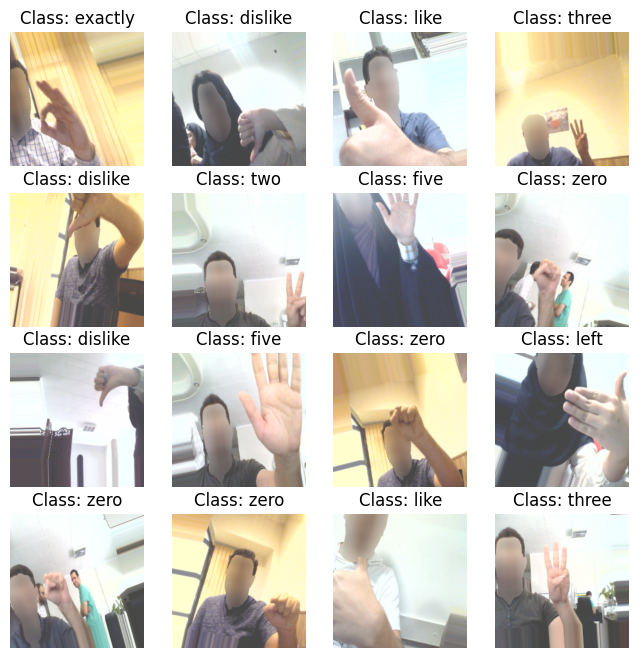

In [28]:
class_mapping = train_generator.class_indices

# Reverse the mapping to get {class_index: class_name}
class_mapping = {v: k for k, v in class_mapping.items()}

# Visualize some images from the training generator
x_batch, y_batch = train_generator.next()
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'Class: {class_mapping[int(y_batch[i])]}')
    plt.axis('off')
plt.show()


### Model Architecture:

- **Convolutional Layers:** Five Conv2D layers with relu activation and BatchNormalization.
- **Pooling Layers:** MaxPooling2D layers after each convolutional block.
- **Dropout Layer:** To prevent overfitting.
- **Dense Layer:** Final dense layer with softmax activation for classification into 8 categories.


In [11]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.BatchNormalization(momentum=0.55))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization(momentum=0.55))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization(momentum=0.55))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization(momentum=0.55))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(265, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization(momentum=0.55))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(265, (3, 3),padding='same', activation='relu'))
model.add(layers.BatchNormalization(momentum=0.55))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.7))
model.add(layers.Dense(8, activation='softmax'))


In [12]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 128)     3584      
                                                                 
 batch_normalization_6 (Bat  (None, 224, 224, 128)     512       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 74, 74, 128)       147584    
                                                                 
 batch_normalization_7 (Bat  (None, 74, 74, 128)       512       
 chNormalization)                                                
                                                      

### Train The Model

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.3e-4),
              metrics=['acc'])

In [16]:
history = model.fit(train_generator, epochs=45, validation_data=validation_generator)

Epoch 1/45
91/91 [==============================] - 154s 2s/step - loss: 2.7464 - acc: 0.2277 - val_loss: 1.6043 - val_acc: 0.4180
Epoch 2/45
91/91 [==============================] - 93s 1s/step - loss: 2.3159 - acc: 0.3002 - val_loss: 2.1148 - val_acc: 0.3470
Epoch 3/45
91/91 [==============================] - 90s 991ms/step - loss: 2.0873 - acc: 0.3597 - val_loss: 1.7015 - val_acc: 0.4290
Epoch 4/45
91/91 [==============================] - 102s 1s/step - loss: 2.0357 - acc: 0.3987 - val_loss: 1.3560 - val_acc: 0.5268
Epoch 5/45
91/91 [==============================] - 93s 1s/step - loss: 1.8572 - acc: 0.4296 - val_loss: 1.5660 - val_acc: 0.5268
Epoch 6/45
91/91 [==============================] - 94s 1s/step - loss: 1.7615 - acc: 0.4792 - val_loss: 2.3137 - val_acc: 0.4763
Epoch 7/45
91/91 [==============================] - 91s 988ms/step - loss: 1.6090 - acc: 0.5286 - val_loss: 2.4720 - val_acc: 0.4416
Epoch 8/45
91/91 [==============================] - 93s 1s/step - loss: 1.3468 - a

In [20]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
91/91 [==============================] - 89s 975ms/step - loss: 0.1174 - acc: 0.9638 - val_loss: 0.0436 - val_acc: 0.9858
Epoch 2/10
91/91 [==============================] - 89s 979ms/step - loss: 0.0924 - acc: 0.9702 - val_loss: 0.1181 - val_acc: 0.9716
Epoch 3/10
91/91 [==============================] - 90s 989ms/step - loss: 0.0804 - acc: 0.9749 - val_loss: 0.0421 - val_acc: 0.9826
Epoch 4/10
91/91 [==============================] - 92s 1s/step - loss: 0.0881 - acc: 0.9735 - val_loss: 0.0329 - val_acc: 0.9890
Epoch 5/10
91/91 [==============================] - 95s 1s/step - loss: 0.1116 - acc: 0.9662 - val_loss: 0.0560 - val_acc: 0.9842
Epoch 6/10
91/91 [==============================] - 93s 1s/step - loss: 0.0826 - acc: 0.9735 - val_loss: 0.5396 - val_acc: 0.8470
Epoch 7/10
91/91 [==============================] - 92s 1s/step - loss: 0.1305 - acc: 0.9579 - val_loss: 0.0597 - val_acc: 0.9842
Epoch 8/10
91/91 [==============================] - 92s 1s/step - loss: 0.1123 - 

### Evaluate Model on The Test Set

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
        'test/',
        target_size=(224, 224),
        class_mode='sparse')

Found 1590 images belonging to 8 classes.


In [22]:
model.evaluate(test_gen)

50/50 [==============================] - 15s 293ms/step - loss: 0.4243 - acc: 0.8931


[0.4242600202560425, 0.893081784248352]

### Save The Model

Saving the trained model allows us to utilize it for real-time hand gesture classification using a webcam (next notebook)

In [23]:
model.save('model.h5')